# W stability in turbulent odor backgrounds
Look at a 6-odor case, use a large $\Lambda$ scale in the IBCM model or the PCA model that just makes the W numerical integration blow up, and check whether this is reflected by the stability anaysis of either the Euler integrator or the equation's fixed point itself. 

## Imports

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import perf_counter
import os, json
import sys
sys.path.insert(1, "../")

from modelfcts.ibcm import (
    integrate_inhib_ibcm_network_options,
    compute_mbars_cgammas_cbargammas
)
from modelfcts.ibcm_analytics import (
    fixedpoint_thirdmoment_exact, 
    fixedpoint_thirdmoment_perturbtheory,
    ibcm_fixedpoint_w_thirdmoment, 
    ibcm_all_largest_eigenvalues
)
from modelfcts.biopca import (
    integrate_inhib_ifpsp_network_skip,
    build_lambda_matrix,
    biopca_respond_new_odors
)
from modelfcts.ideal import (
    find_projector, 
    find_parallel_component, 
    ideal_linear_inhibitor, 
    compute_optimal_factor
)
from modelfcts.checktools import (
    check_conc_samples_powerlaw_exp1,
    compute_pca_meankept, 
    compute_projector_series, 
    analyze_pca_learning, 
    jacobian_row_wmat_l2_avgstats,
    stability_row_wmat_l2_instant
)
from modelfcts.backgrounds import (
    update_powerlaw_times_concs, 
    logof10, 
    sample_background_powerlaw,
    sample_ss_conc_powerlaw, 
    decompose_nonorthogonal_basis, 
    update_alternating_inputs, 
    generate_odorant
)
from utils.statistics import seed_from_gen
from modelfcts.distribs import (
    truncexp1_inverse_transform, 
    truncexp1_density, 
    truncexp1_average,
    powerlaw_cutoff_inverse_transform
)
from simulfcts.plotting import (
    plot_cbars_gammas_sums, 
    plot_cbars_gamma_series, 
    plot_3d_series, 
    plot_w_matrix, 
    plot_background_norm_inhibition, 
    plot_background_neurons_inhibition, 
    plot_pca_results, 
    hist_outline
)
from simulfcts.analysis import compute_back_reduction_stats
from utils.metrics import jaccard, l1_norm, l2_norm, linf_norm, cosine_dist
from utils.smoothing_function import moving_average

/Users/fb3/Documents/Physique/phd/research/olfactory_habituation/secondary_scripts/../modelfcts/checktools.py:131: SyntaxWarning: invalid escape sequence '\T'
  """ Function to compute the second time derivative of the IBCM model
/Users/fb3/Documents/Physique/phd/research/olfactory_habituation/secondary_scripts/../simulfcts/plotting.py:301: SyntaxWarning: invalid escape sequence '\s'
  """ Plot the time course of sums of dot products


### Aesthetic parameters

In [2]:
#plt.style.use(['dark_background'])
plt.rcParams["figure.figsize"] = (4.5, 3.0)

In [3]:
models = ["ibcm", "biopca", "avgsub", "ideal", "orthogonal", "none"]
model_nice_names = {
    "ibcm": "IBCM",
    "biopca": "BioPCA",
    "avgsub": "Average",
    "ideal": "Ideal",
    "orthogonal": "Orthogonal",
    "none": "None"
}
model_colors = {
    "ibcm": "xkcd:turquoise",
    "biopca": "xkcd:orangey brown",
    "avgsub": "xkcd:navy blue",
    "ideal": "xkcd:powder blue",
    "orthogonal": "xkcd:pale rose",
    "none": "grey"
}

### Initialization

In [4]:
# Initialize common simulation parameters
n_dimensions = 25  # Half the real number for faster simulations
n_components = 6  # Number of background odors

inhib_rates = [0.0001, 0.00002]  # alpha, beta  [0.00025, 0.00005]

# Simulation duration
duration = 360000.0
deltat = 1.0
n_chunks = 10
skp = 1 * int(1.0 / deltat)

# Common model options
activ_function = "identity"  #"ReLU"

# Background process
update_fct = update_powerlaw_times_concs

# Choose randomly generated background vectors
rgen_meta = np.random.default_rng(seed=0x8896ce0154295ba29df7e93dc277af2d)
#rgen_meta = np.random.default_rng(seed=0x85dfce01542492a29df7e93dc277ad2d)
back_components = np.zeros([n_components, n_dimensions])
for i in range(n_components):
    back_components[i] = generate_odorant(n_dimensions, rgen_meta, lambda_in=0.1)
back_components = back_components / l2_norm(back_components).reshape(-1, 1)

# Seed for background simulation, to make sure all models are the same
simul_seed = seed_from_gen(rgen_meta)

# Turbulent background parameters: same rates and constants for all odors
back_params = [
    np.asarray([1.0] * n_components),        # whiff_tmins
    np.asarray([500.] * n_components),       # whiff_tmaxs
    np.asarray([1.0] * n_components),        # blank_tmins
    np.asarray([800.0] * n_components),      # blank_tmaxs
    np.asarray([0.6] * n_components),        # c0s
    np.asarray([0.5] * n_components),        # alphas
]
back_params.append(back_components)

# Initial values of background process variables (t, c for each variable)
init_concs = sample_ss_conc_powerlaw(*back_params[:-1], size=1, rgen=rgen_meta)
init_times = powerlaw_cutoff_inverse_transform(
                rgen_meta.random(size=n_components), *back_params[2:4])
tc_init = np.stack([init_times, init_concs.squeeze()], axis=1)

# Initial background vector 
init_bkvec = tc_init[:, 1].dot(back_components)
# nus are first in the list of initial background params
init_back_list = [tc_init, init_bkvec]

### Pairwise similarity between background odors
Determines how well-posed the PCA is and how easy it is for the IBCM model to disentangle odors


## IBCM habituation
### IBCM simulation

In [5]:
# IBCM model parameters
n_i_ibcm = 24  # Number of inhibitory neurons for IBCM case

# Model rates
learnrate_ibcm = 0.00125  #5e-5
tau_avg_ibcm = 1600  # 2000
coupling_eta_ibcm = 0.6/n_i_ibcm
ssat_ibcm = 50.0
k_c2bar_avg = 0.1
decay_relative_ibcm = 0.005
lambd_ibcm = 3.0
ibcm_rates = [
    learnrate_ibcm, 
    tau_avg_ibcm, 
    coupling_eta_ibcm, 
    lambd_ibcm,
    ssat_ibcm, 
    k_c2bar_avg,
    decay_relative_ibcm 
]
ibcm_options = {
    "activ_fct": activ_function, 
    "saturation": "tanh", 
    "variant": "law", 
    "decay": True
}

# Initial synaptic weights: small positive noise
init_synapses_ibcm = 0.3*rgen_meta.standard_normal(size=[n_i_ibcm, n_dimensions])*lambd_ibcm

In [6]:
def recompute_theta_series(cbser, tau, dt):
    theta = np.zeros([cbser.shape[0], cbser.shape[1]])
    theta[0] = cbser[0]**2
    for i in range(cbser.shape[0]-1):
        theta[i+1] = theta[i] + dt/tau*(cbser[i]*cbser[i] - theta[i])
    return theta

In [7]:
# Run the IBCM simulations
# Perform successive shorter runs/restarts for memory efficiency
tser_ibcm = []
nuser_ibcm = []
bkvecser_ibcm = []
mser_ibcm = []
cbarser_ibcm = []
wser_ibcm = []
sser_ibcm = []
thetaser_ibcm = []
if n_chunks > 1:
    seed_spawns = np.random.SeedSequence(simul_seed).spawn(10)
else:
    seed_spawns = [simul_seed]
for i in range(n_chunks):
    tstart = perf_counter()
    if i == 0:
        init_vari = init_synapses_ibcm
        init_back = init_back_list
    else:
        init_vari = [mser_ibcm[i-1][-1], thetaser_ibcm[i-1][-1], wser_ibcm[i-1][-1]]
        init_back = [nuser_ibcm[i-1][-1], bkvecser_ibcm[i-1][-1]]
    sim_results = integrate_inhib_ibcm_network_options(
                init_vari, update_fct, init_back, 
                ibcm_rates, inhib_rates, back_params, duration/n_chunks, 
                deltat, seed=seed_spawns[i], noisetype="uniform",  
                skp=skp, **ibcm_options
    )
    tser_ibcm.append(sim_results[0] + i/n_chunks*duration)
    nuser_ibcm.append(sim_results[1])
    bkvecser_ibcm.append(sim_results[2])
    mser_ibcm.append(sim_results[3]) 
    cbarser_ibcm.append(sim_results[4]) 
    thetaser_ibcm.append(sim_results[5])
    wser_ibcm.append(sim_results[6])
    sser_ibcm.append(sim_results[7])
    tend = perf_counter()
    print("Finished chunk", i, "in {:.2f} s".format(tend - tstart))

# Concatenate
tser_ibcm = np.concatenate(tser_ibcm, axis=0)
nuser_ibcm = np.concatenate(nuser_ibcm)
bkvecser_ibcm = np.concatenate(bkvecser_ibcm)
mser_ibcm = np.concatenate(mser_ibcm)
cbarser_ibcm = np.concatenate(cbarser_ibcm)
thetaser_ibcm = np.concatenate(thetaser_ibcm)
wser_ibcm = np.concatenate(wser_ibcm)
sser_ibcm = np.concatenate(sser_ibcm)

Finished chunk 0 in 1.19 s
Finished chunk 1 in 1.17 s
Finished chunk 2 in 1.14 s
Finished chunk 3 in 1.15 s
Finished chunk 4 in 1.13 s
Finished chunk 5 in 1.16 s
Finished chunk 6 in 1.14 s


/Users/fb3/Documents/Physique/phd/research/olfactory_habituation/secondary_scripts/../modelfcts/ibcm.py:433: RuntimeWarning: invalid value encountered in add
  wmat += dt * (alpha_term - beta_term)


Finished chunk 7 in 1.14 s
Finished chunk 8 in 1.14 s
Finished chunk 9 in 1.15 s


### IBCM habituation analysis

In [8]:
# Calculate cgammas_bar and mbars
transient = int(5/6*duration / deltat) // skp
# Dot products \bar{c}_{\gamma} = \bar{\vec{m}} \cdot \vec{x}_{\gamma}
mbarser, c_gammas, cbars_gamma = compute_mbars_cgammas_cbargammas(
                                    mser_ibcm, coupling_eta_ibcm, back_components)
sums_cbars_gamma = np.sum(cbars_gamma, axis=2)
sums_cbars_gamma2 = np.sum(cbars_gamma*cbars_gamma, axis=2)

# Analytical prediction, exact: need moments of nu. Easiest to compute numerically. 
conc_ser = nuser_ibcm[:, :, 1]
# Odors are all iid so we can average over all odors
mean_conc = np.mean(conc_ser)
sigma2_conc = np.var(conc_ser)
thirdmom_conc = np.mean((conc_ser - mean_conc)**3)
moments_conc = [mean_conc, sigma2_conc, thirdmom_conc]

# Analytical prediction
res = fixedpoint_thirdmoment_exact(moments_conc, 1, n_components-1, lambd=lambd_ibcm)
c_specif, c_nonspecif = res[:2]
cs_cn = res[:2]

# Count how many dot products are at each possible value. Use cbar = 1.0 as a split. 
split_val = 2.0 * lambd_ibcm
cbars_gamma_mean = np.mean(cbars_gamma[transient:], axis=0)
cgammas_bar_counts = {"above": int(np.sum(cbars_gamma_mean.flatten() > split_val)), 
                      "below": int(np.sum(cbars_gamma_mean.flatten() <= split_val))}
print(cgammas_bar_counts)

specif_gammas = np.argmax(np.mean(cbars_gamma[transient:], axis=0), axis=1)
print(specif_gammas)

# Analytical W
analytical_w = ibcm_fixedpoint_w_thirdmoment(inhib_rates, moments_conc, back_components, cs_cn, specif_gammas)

{'above': 24, 'below': 120}
[3 0 3 1 3 3 5 5 1 0 5 4 1 3 5 2 2 4 4 1 2 0 5 5]


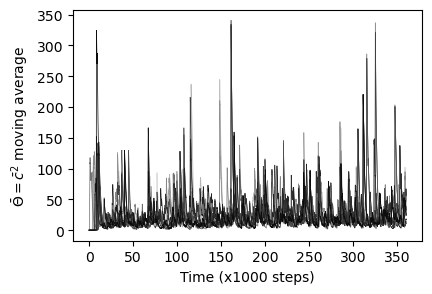

In [9]:
fig, ax = plt.subplots()
#ax.plot(tser_ibcm[:300], nuser_ibcm[:300, :, 1])
neurons_cmap = sns.color_palette("Greys", n_colors=n_i_ibcm)
for i in range(n_i_ibcm):
    ax.plot(tser_ibcm/1000, thetaser_ibcm[:, i], lw=0.5, color=neurons_cmap[i])
ax.set(xlabel="Time (x1000 steps)", ylabel=r"$\bar{\Theta} = \bar{c}^2$ moving average")
plt.show()
plt.close()

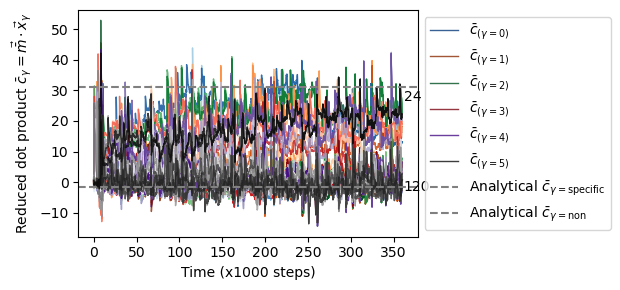

In [10]:
fig , ax, _ = plot_cbars_gamma_series(tser_ibcm, cbars_gamma, 
                        skp=20, transient=320000 // skp)
# Compare to exact analytical fixed point solution
#ax.set_xlim([350, 360])
ax.axhline(c_specif, ls="--", color="grey", 
           label=r"Analytical $\bar{c}_{\gamma=\mathrm{specific}}$")
ax.axhline(c_nonspecif, ls="--", color="grey", 
           label=r"Analytical $\bar{c}_{\gamma=\mathrm{non}}$")
fig.tight_layout()
leg = ax.legend(loc="upper left", bbox_to_anchor=(1., 1.))

#fig.savefig("figures/powerlaw/cbargammas_series_turbulent_background_example.pdf", 
#            transparent=True, bbox_inches="tight", bbox_extra_artists=(leg,))
plt.show()
plt.close()

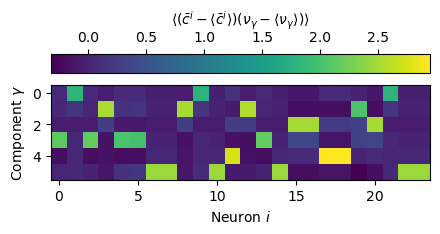

Number of neurons specific to component 0: 3
Number of neurons specific to component 1: 4
Number of neurons specific to component 2: 3
Number of neurons specific to component 3: 5
Number of neurons specific to component 4: 3
Number of neurons specific to component 5: 6


In [11]:
# Correlation between nu's and c's, see if some neurons are specific to odors
# Each neuron turns out to correlate its response to  one concentration
# that means it is specific to that odor. 
cbarser_norm_centered = cbarser_ibcm - np.mean(cbarser_ibcm[transient:], axis=0)
conc_ser_centered = (nuser_ibcm[:, :, 1] 
                     - np.mean(nuser_ibcm[transient:, :, 1], axis=0))
correl_c_nu = np.mean(cbarser_norm_centered[transient:, :, None] 
                      * conc_ser_centered[transient:, None, :], axis=0)

fig, ax = plt.subplots()
img = ax.imshow(correl_c_nu.T)
ax.set(ylabel=r"Component $\gamma$", xlabel=r"Neuron $i$")
fig.colorbar(img, label=r"$\langle (\bar{c}^i - \langle \bar{c}^i \rangle)"
             r"(\nu_{\gamma} - \langle \nu_{\gamma} \rangle) \rangle$", 
            location="top")
fig.tight_layout()
plt.show()
plt.close()

# Check if each component has at least one neuron
for comp in range(n_components):
    print("Number of neurons specific to component {}: {}".format(
            comp, np.sum(np.mean(cbars_gamma[-2000:, :, comp], axis=0) > split_val*1.5)))

Mean activity norm reduced to nan % of input
Standard deviation of activity norm reduced to nan % of input


/Users/fb3/Documents/Physique/phd/research/olfactory_habituation/secondary_scripts/../utils/metrics.py:19: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(vecs**2, axis=axis))
/Users/fb3/miniforge3/envs/py312/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


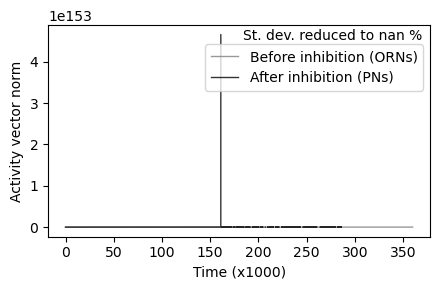

In [12]:
fig, ax, bknorm_ser, snorm_ser = plot_background_norm_inhibition(
                                tser_ibcm, bkvecser_ibcm, sser_ibcm, skp=1)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, snorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
plt.show()
plt.close()

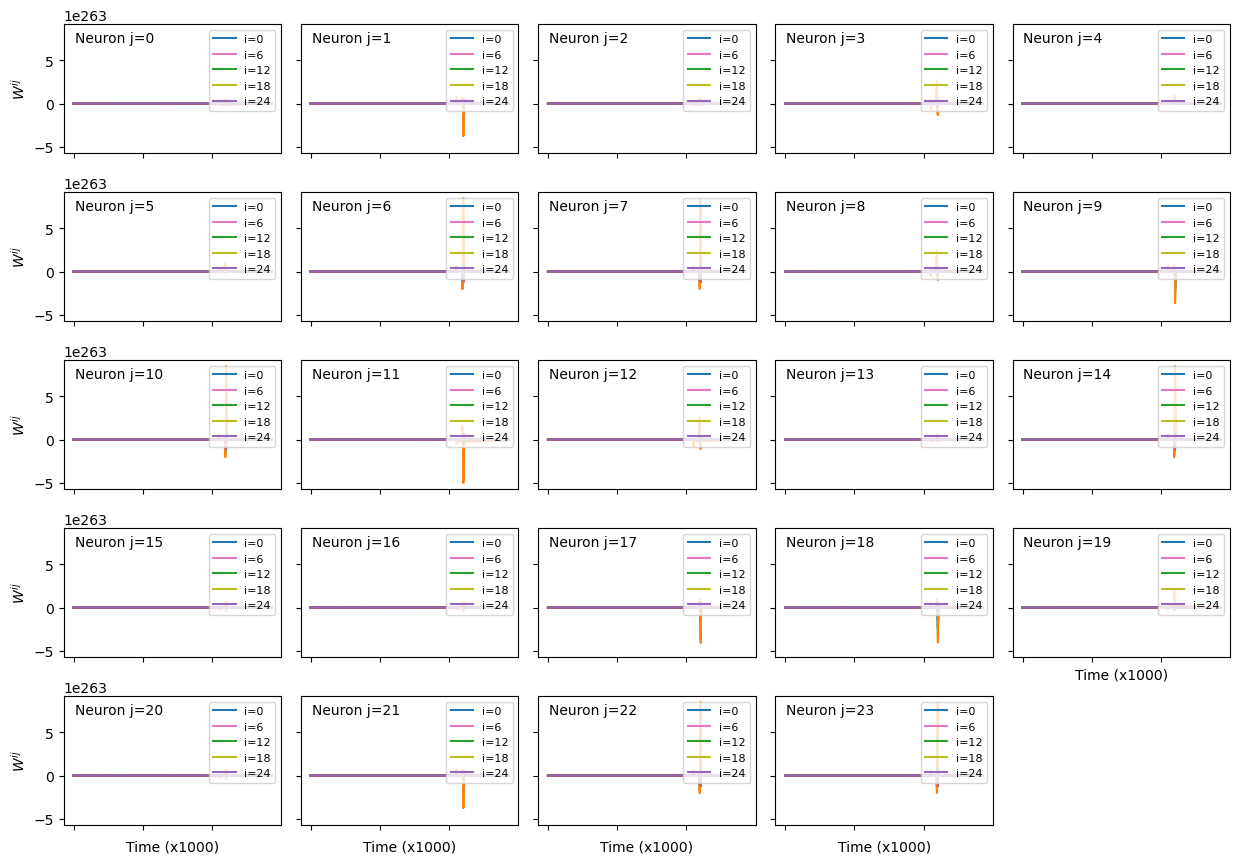

In [13]:
fig, axes = plot_w_matrix(tser_ibcm, wser_ibcm, skp=100)
fig.tight_layout()
plt.show()
plt.close()

### Stability of average fixed points
Check the eigenvalues of the jacobian for one neuron, for every possible specificity. There are $2^{n_B}$ possibilities: choosing specific or not for each odor. 

Also check the stability of the W matrix equation. 

In [14]:
all_max_eigenvalues = ibcm_all_largest_eigenvalues(
    moments_conc, ibcm_rates, back_components, m3=1.0, cut=1e-16, options=ibcm_options
)

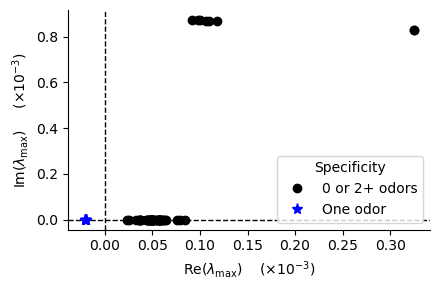

In [15]:
fig, ax = plt.subplots()
ibcm_specif_keys = list(all_max_eigenvalues.keys())
ibcm_eig_values = np.asarray([all_max_eigenvalues[a] for a in ibcm_specif_keys])
reals, imags = np.real(ibcm_eig_values), np.imag(ibcm_eig_values)
ibcm_eig_values_specif1 = np.asarray([len(s) == 1 for s in ibcm_specif_keys], dtype=bool)
highlights = ibcm_eig_values_specif1
ax.axvline(0.0, ls="--", color="k", lw=1.0)
ax.axhline(0.0, ls="--", color="k", lw=1.0)
scaleup = 1e3
ax.plot(reals[~highlights]*scaleup, imags[~highlights]*scaleup, marker="o", mfc="k", mec="k", 
       ls="none", label="0 or 2+ odors", ms=6)
ax.plot(reals[highlights]*scaleup, imags[highlights]*scaleup, marker="*", mfc="b", mec="b", 
        ls="none", label="One odor", ms=8)
for side in ("top", "right"):
    ax.spines[side].set_visible(False)
ax.legend(title="Specificity")
ax.set(xlabel=r"$\mathrm{Re}(\lambda_{\mathrm{max}})$    ($\times 10^{-3}$)", 
      ylabel=r"$\mathrm{Im}(\lambda_{\mathrm{max}})$     ($\times 10^{-3}$)")
fig.tight_layout()
plt.show()
plt.close()

## Understand what happens when $W$ blows up

In [16]:
# Check the fixed point stability for W.
# Use analytical cgammas assigned based on the neurons' specificities in this simulation
cgammas_mat = np.full([n_i_ibcm, n_components], fill_value=c_nonspecif)
cgammas_mat[np.arange(n_i_ibcm), specif_gammas] = c_specif
jac_w = jacobian_row_wmat_l2_avgstats(cgammas_mat, moments_conc[:2], inhib_rates)
jac_w_eigvals = np.linalg.eigvalsh(jac_w)
if np.all(np.real(jac_w_eigvals) < 0):
    print("W fixed point is stable, jacobian eigenvalues all negative")
    print("Largest eigenvalue:", jac_w_eigvals.max())
    print("Smallest eigenvalue:", jac_w_eigvals.min())
else:
    print("W fixed point unstable, some eigenvalues positive")
    print("All eigenvalues:", jac_w_eigvals[::-1])

W fixed point is stable, jacobian eigenvalues all negative
Largest eigenvalue: -1.9999999999978524e-05
Smallest eigenvalue: -0.07041889897873059


Blow-up detected at time 8084.0 , index 8084 for Lambda = 3.0
Euler eigenvalues then: [-1.67583304  0.99998     0.99998     0.99998     0.99998     0.99998
  0.99998     0.99998     0.99998     0.99998     0.99998     0.99998
  0.99998     0.99998     0.99998     0.99998     0.99998     0.99998
  0.99998     0.99998     0.99998     0.99998     0.99998     0.99998   ]


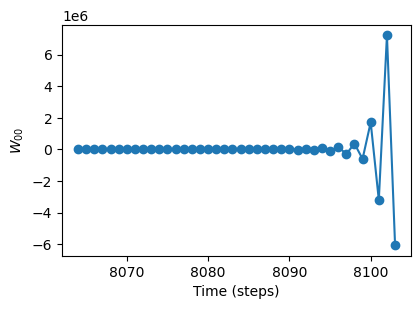

Conclusion: this is a numerical instability of the Euler integrator


In [17]:
# Find a blowup instance
idx_blow = np.argmax(wser_ibcm[:, 0, 0] > 1e2)
if idx_blow > 0:
    t_blow = tser_ibcm[idx_blow]
    print("Blow-up detected at time", t_blow, ", index", idx_blow, 
          "for Lambda = {}".format(lambd_ibcm))

    # Compute the numerical stability at that point
    euler_eigvals = stability_row_wmat_l2_instant(cbarser_ibcm[idx_blow], inhib_rates, deltat)
    print("Euler eigenvalues then:", euler_eigvals)
    
    # Plot the w time series then
    fig, ax = plt.subplots()
    slic = slice(idx_blow-20, idx_blow+20, 1)
    ax.plot(tser_ibcm[slic], wser_ibcm[slic, 0, 0], marker="o")
    ax.set(xlabel="Time (steps)", ylabel=r"$W_{00}$")
    plt.show()
    plt.close()
    
    if np.any(np.abs(euler_eigvals) > 1.0):
        print("Conclusion: this is a numerical instability of the Euler integrator")
    else:
        print("Cannot identify the reason of this instability")

else:
    print("No blowup found for Lambda = {}".format(lambd_ibcm))
    # Compute Euler eigenvalues over time, at different steps, check if they
    # ever go below -1 or above 1. 
    largest_abs_eigval_ser = []
    smallest_abs_eigval_ser = []
    ev_skp = 1
    for i in range(0, tser_ibcm.shape[0], ev_skp):
        euler_eigvals = stability_row_wmat_l2_instant(cbarser_ibcm[i], inhib_rates, deltat)
        largest_abs_eigval_ser.append(np.abs(euler_eigvals).max())
        smallest_abs_eigval_ser.append(abs(euler_eigvals[0]))
    largest_abs_eigval_ser = np.asarray(largest_abs_eigval_ser)
    problematic_points = (largest_abs_eigval_ser > 1.0)
    if not np.any(problematic_points):
        print("Confirmed by the stability analysis: no time where an eigenvalue "
              + "has a magnitude > 1")
    else:
        print("This is despite having found an eigenvalue > 1, see plot below")
    # Plotting to confirm
    fig, ax = plt.subplots()
    ax.plot(tser_ibcm[::ev_skp]/1000.0, largest_abs_eigval_ser, label="Largest")
    ax.plot(np.arange(0.0, duration, deltat*ev_skp)[problematic_points]/1000.0, 
            largest_abs_eigval_ser[problematic_points], "ro", label="Problem (if any)")
    #ax.plot(tser_ibcm[::100]/1000.0, smallest_abs_eigval_ser, label="Smallest")
    ax.legend()
    ax.set(xlabel="Time (x1000 steps)", ylabel="Euler eigenvalues magnitude")
    ax.axhline(1.0, ls="--", color="grey")
    plt.show()
    plt.close()

In [18]:
# Maximal Lambda for stability: we need dt*(beta + alpha Lambda**2 csat**2) < 2
# to ensure eigenvalue magnitude < 1
lambda_max = np.sqrt((2.0 / deltat - inhib_rates[1])/(inhib_rates[0]*ssat_ibcm**2))
print("Largest safe Lambda for IBCM:", lambda_max)

Largest safe Lambda for IBCM: 2.828412982575211


## BioPCA simulation
### BioPCA habituation simulation

Also try to choose a $\Lambda$ which creates blow-ups in $W$. 

Note that in the PCA model, as in IBCM, it is entirely $M$ which is scaled by $\Lambda$. The matrix $L' = L^{-1}$, which is returned by my integration function, has the PCA's principal values on its diagonal, irrespective of $\Lambda$. Meanwhile, $M$ is scaled with $\Lambda$ and $L'$, so $\Lambda^{-1} L'^{-1}M = U$, the matrix of orthonormal eigenvectors from the PCA (vectors are the rows of $U$), while the projector $LM$ still has scale $\Lambda_i$ for the eigenvector in row $i$.

In BioPCA, $\vec{\overline{c}} = LM \vec{x}$, so it also has scale $\Lambda$ in it. 

In [ ]:
# BioPCA model parameters
n_i_pca = n_components  # Number of inhibitory neurons for BioPCA case

# Model rates
learnrate_pca = 1e-4  # Learning rate of M
# Choose Lambda diagonal matrix as advised in Minden et al., 2018
# but scale it up to counteract W regularization
lambda_range_pca = 0.5
lambda_max_pca = 40.0
# Learning rate of L, relative to learnrate. Adjusted to Lambda in the integration function
rel_lrate_pca = 2.0  #  / lambda_max_pca**2 
lambda_mat_diag = build_lambda_matrix(lambda_max_pca, lambda_range_pca, n_i_pca)

xavg_rate_pca = learnrate_pca
pca_options = {
    "activ_fct": activ_function, 
    "remove_lambda": False, 
    "remove_mean": True
}
biopca_rates = [learnrate_pca, rel_lrate_pca, lambda_max_pca, lambda_range_pca, xavg_rate_pca]


# Initial synaptic weights: small positive noise
rgen_pca = np.random.default_rng(seed=0x8b6664612cfeda4a121436fcfbbca449)
init_synapses_pca = rgen_pca.standard_normal(size=[n_i_pca, n_dimensions]) / np.sqrt(n_i_pca)
init_mmat_pca = rgen_pca.standard_normal(size=[n_i_pca, n_dimensions]) / np.sqrt(n_dimensions)
init_lmat_pca = np.eye(n_i_pca, n_i_pca)  # Supposed to be near-identity, start as identity
ml_inits_pca = [init_mmat_pca, init_lmat_pca]

In [ ]:
# Run simulation
sim_results = integrate_inhib_ifpsp_network_skip(
                ml_inits_pca, update_fct, init_back_list, biopca_rates, 
                inhib_rates, back_params, duration, deltat, 
                seed=simul_seed, noisetype="uniform", skp=skp, **pca_options)
(tser_pca, 
 nuser_pca, 
 bkvecser_pca, 
 mser_pca, 
 lser_pca, 
 xser_pca, 
 cbarser_pca, 
 wser_pca, 
 sser_pca) = sim_results

### BioPCA simulation analysis

In [ ]:
res = analyze_pca_learning(bkvecser_pca, mser_pca, lser_pca, 
                           lambda_mat_diag, demean=pca_options["remove_mean"])
true_pca, learnt_pca, fser, off_diag_l_avg_abs, align_error_ser = res

In [ ]:
from utils.statistics import principal_component_analysis
from modelfcts.checktools import compute_pca_meankept

In [ ]:
fig, axes = plot_pca_results(tser_pca/1000, true_pca, learnt_pca, align_error_ser, 
                             off_diag_l_avg_abs, skp=20)
axes[-1].set_xlabel("Time (x1000 steps)")
fig.set_size_inches(fig.get_size_inches()[0], 3*2.5)
plt.show()
plt.close()

In [ ]:
fig, ax, bknorm_ser, snorm_ser = plot_background_norm_inhibition(
                                tser_pca, bkvecser_pca, sser_pca, skp=10)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, snorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
fig, axes, _ = plot_background_neurons_inhibition(tser_pca, bkvecser_pca, sser_pca, skp=10)
plt.show()
plt.close()

In [ ]:
fig, axes = plot_w_matrix(tser_pca, wser_pca, skp=10)
plt.show()
plt.close()

### Check for W blowups in the PCA simulation

In [ ]:
# Check the stability of the W fixed point by
# computing the c_gammas matrix from the simulation
projmean_pca = np.mean(fser[:transient*2], axis=0)
cgammas_pca = projmean_pca.dot(back_components.T)

jac_w = jacobian_row_wmat_l2_avgstats(cgammas_pca, moments_conc[:2], inhib_rates)
jac_w_eigvals = np.linalg.eigvalsh(jac_w)
if np.all(np.real(jac_w_eigvals) < 0):
    print("W fixed point is stable, jacobian eigenvalues all negative")
    print("Largest eigenvalue:", jac_w_eigvals.max())
    print("Smallest eigenvalue:", jac_w_eigvals.min())
else:
    print("W fixed point unstable, some eigenvalues positive")
    print("All eigenvalues:", jac_w_eigvals[::-1])

In [ ]:
# Find a blowup instance
idx_blow = np.argmax(wser_pca[:, 0, 0] > 1e2)
if idx_blow > 0:
    t_blow = tser_pca[idx_blow]
    print("Blow-up detected at time", t_blow, ", index", idx_blow, 
          "for Lambda = {}".format(lambda_max_pca))

    # Compute the numerical stability at that point
    euler_eigvals = stability_row_wmat_l2_instant(cbarser_pca[idx_blow], inhib_rates, deltat)
    print("Euler eigenvalues then:", euler_eigvals)
    
    # Plot the w time series then
    fig, ax = plt.subplots()
    slic = slice(idx_blow-20, idx_blow+20, 1)
    ax.plot(tser_pca[slic], wser_pca[slic, 0, 0], marker="o")
    ax.set(xlabel="Time (steps)", ylabel=r"$W_{00}$")
    plt.show()
    plt.close()
    
    if np.any(np.abs(euler_eigvals) > 1.0):
        print("Conclusion: this is a numerical instability of the Euler integrator")
    else:
        print("Cannot identify the reason of this instability")

else:
    print("No blowup found for Lambda = {}".format(lambda_max_pca))
    # Compute Euler eigenvalues over time, at different steps, check if they
    # ever go below -1 or above 1. 
    largest_abs_eigval_ser = []
    smallest_abs_eigval_ser = []
    ev_skp = 1
    for i in range(0, tser_pca.shape[0], ev_skp):
        euler_eigvals = stability_row_wmat_l2_instant(cbarser_pca[i], inhib_rates, deltat)
        largest_abs_eigval_ser.append(np.abs(euler_eigvals).max())
        smallest_abs_eigval_ser.append(abs(euler_eigvals[0]))
    largest_abs_eigval_ser = np.asarray(largest_abs_eigval_ser)
    problematic_points = (largest_abs_eigval_ser > 1.0)
    if not np.any(problematic_points):
        print("Confirmed by the stability analysis: no time where an eigenvalue "
              + "has a magnitude > 1")
    else:
        print("This is despite having found an eigenvalue > 1, see plot below")
    # Plotting to confirm
    fig, ax = plt.subplots()
    ax.plot(tser_pca[::ev_skp]/1000.0, largest_abs_eigval_ser, label="Largest")
    ax.plot(np.arange(0.0, duration, deltat*ev_skp)[problematic_points]/1000.0, 
            largest_abs_eigval_ser[problematic_points], "ro", label="Problem (if any)")
    #ax.plot(tser_pca[::100]/1000.0, smallest_abs_eigval_ser, label="Smallest")
    ax.legend()
    ax.set(xlabel="Time (x1000 steps)", ylabel="Euler eigenvalues magnitude")
    ax.axhline(1.0, ls="--", color="grey")
    plt.show()
    plt.close()

In [ ]:
# Maximal Lambda for PCA stability: we need dt*(beta + alpha Lambda**2 c_norm**2) < 2
# to ensure eigenvalue magnitude < 1
# For the typical norm of Lambda*c, use the average norm of the
# PCA simulation's largest c value, c = LMx
# divided by PCA's Lambda scale to recover the default scale for Lambda=1
# Smooth out over a few steps to identify really unstable bouts that would diverge, 
# not a single step where maybe the accuracy is bad but not long enough. 
mean_cbar_pca_norm = np.max(moving_average(cbarser_pca, 9) / lambda_mat_diag)
lambda_max_pca_stable = np.sqrt((2.0 / deltat - inhib_rates[1]) 
                         / (inhib_rates[0]*mean_cbar_pca_norm**2))
print("Largest safe Lambda for PCA:", lambda_max_pca_stable)

In [ ]:
snorm_series = {
    "ibcm": l2_norm(sser_ibcm), 
    "biopca": l2_norm(sser_pca), 
    "avgsub": l2_norm(sser_avg), 
    "none": l2_norm(bkvecser_ibcm), 
    "ideal": l2_norm(sser_ideal)
}
std_options = dict(kernelsize=2001, boundary="free")
mean_options = dict(kernelsize=2001, boundary="free")
std_series = {
    a: np.sqrt(moving_var(snorm_series[a], **std_options)) for a in snorm_series
} 
mean_series = {
    a: moving_average(snorm_series[a], **mean_options) for a in snorm_series
}

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes = axes.flatten()
for model in std_series.keys():
    props = dict(label=model_nice_names[model], color=model_colors[model])
    axes[0].plot(tser_ibcm / 1000, mean_series[model], **props)
    axes[1].plot(tser_ibcm / 1000, std_series[model], **props)
snorm_string = r"$\|\vec{s}\|$"
axes[0].set_ylabel(r"PN activity norm, " + snorm_string)
axes[1].set(xlabel="Time (x1000 steps)", ylabel=r"Standard deviation " + snorm_string)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.tight_layout()
fig.set_size_inches(4.5, 2.5*2)
plt.show()
plt.close()